# NLP Basic 실습 - Text Preprocessing

In [1]:
! pip install konlpy                                            # konlpy installation
! pip install git+https://github.com/haven-jeon/PyKoSpacing.git # PyKoSpacing installation
! pip install hgtk # 한글 자모 단위 처리 패키지 설치

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 11.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-llho19sc
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-llho19sc
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 10.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━

In [25]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!pip install .

[Errno 2] No such file or directory: 'fastText'
/home/vision/Downloads/fastText


In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pykospacing import Spacing
from konlpy.tag import Okt
import hgtk
from gensim.models import Word2Vec

I0000 00:00:1725849567.451441   61216 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## 1. 데이터 로드

- 네이버 쇼핑 리뷰 데이터
- 편의상 일부 전처리한 데이터 사용
    - raw data에 긍/부정 label 추가
    - `pykospacing`으로 띄어쓰기 적용 (시간 다소 소요)

- raw data 다운로드 : https://github.com/bab2min/corpus/tree/master/sentiment

In [5]:
# 데이터 불러오기
data = pd.read_csv("/home/vision/Downloads/naver_shopping.csv", sep = '\t')
data.head()

,ratings,reviews,label
0,5,배공 빠르고 굿,1
1,2,택배가 엉망이 네용 저희 집 밑에 층에 말도 없이 놔두고 가고,0
2,5,아주 좋아요 바지 정말 좋아서 2개 더 구매했어요 이 가격에 대박입니다. 바느질이 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트 색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


## 2. Cleaning


### **정규표현식**

- `re.sub(대체할 패턴, 대체된 결과 형태, 대체할 범위)`
- `^` : not의 의미

In [6]:
# 정규표현식
def cleaning(text) :

    pattern = r'[^가-힣]'   # 한글 단어 제외 모두 공백으로 대체
    text = re.sub(pattern = pattern, repl = ' ', string = text)

    pattern = r'\s+'        # 연속 공백 제거
    text = re.sub(pattern = pattern, repl = ' ', string = text)
    return text

In [7]:
print(f"전처리 전 : {data['reviews'][20]}")

# 정규표현식 적용
data['reviews'] = data['reviews'].apply(cleaning)
print(f"전처리 후 : {data['reviews'][20]}")

전처리 전 : 가성비 괜찮습니다 바퀴가 고정된다면 별 다섯 개짜린 데...
전처리 후 : 가성비 괜찮습니다 바퀴가 고정된다면 별 다섯 개짜린 데 


## 3. 띄어쓰기 교정

`pykospacing` 을 이용하여 띄어쓰기가 되지 않은 문장을 띄어쓰기가 된 문장으로 교정해줍니다. 연속 공백도 하나의 공백으로 처리해줍니다.

시간 소요가 큰 관계로 사전에 띄어쓰기 적용

In [ ]:
'''
spacing = Spacing()

def spacing_text(text):
    text = spacing(text)
    return text

tqdm.pandas()

data['reviews'] = data['reviews'].progress_apply(spacing_text) # 진행 상황 표시
'''

## 4. Tokenization



In [8]:
okt = Okt()

def tokenizing(text) :
    tokenized = okt.morphs(text, stem=True)
    return tokenized

In [12]:
print(f"토큰화 결과 : {tokenizing(data['reviews'][20])}")

토큰화 결과 : ['가성', '비', '괜찮다', '바퀴', '가', '고정', '되다', '별', '다섯', '개', '짜다', '린', '데']


위 토큰화 결과 예시에서 볼 수 있듯이, `가성비`를 `가성`, `비`로 토큰화하는 경우가 나타났습니다.

이러한 경우, 아래와 같은 방법으로 **konlpy 사전에 단어를 추가**할 수 있습니다.

Colab 파일에서 konlpy 폴더에 임시폴더를 만들어 새로운 단어를 추가한 뒤, 원본 폴더에 다시 저장해줍니다.

<br>

📍경로 오류가 발생한 경우, 주로 python 버전이 다른 것이 원인이므로, 본인에게 맞는 파일 경로로 설정해주세요!


In [22]:
import os

os.chdir('/home/vision/anaconda3/envs/test/lib/python3.10/site-packages/konlpy/java') # 경로 이동
os.getcwd()
os.makedirs('./aa') # 임시폴더 생성

In [23]:
os.chdir('./aa') #임시 폴더로 이동
os.getcwd()

'/home/vision/anaconda3/envs/test/lib/python3.10/site-packages/konlpy/java/aa'

In [28]:
# 임시폴더에 사전파일 압축 해제
!unzip ../open-korean-text-2.1.0.jar -d ./aa

Archive:  ../open-korean-text-2.1.0.jar
   creating: ./aa/META-INF/
  inflating: ./aa/META-INF/MANIFEST.MF  
   creating: ./aa/org/
   creating: ./aa/org/openkoreantext/
   creating: ./aa/org/openkoreantext/processor/
   creating: ./aa/org/openkoreantext/processor/normalizer/
   creating: ./aa/org/openkoreantext/processor/phrase_extractor/
   creating: ./aa/org/openkoreantext/processor/qa/
   creating: ./aa/org/openkoreantext/processor/stemmer/
   creating: ./aa/org/openkoreantext/processor/tokenizer/
   creating: ./aa/org/openkoreantext/processor/tools/
   creating: ./aa/org/openkoreantext/processor/util/
   creating: ./aa/org/openkoreantext/processor/util/adjective/
   creating: ./aa/org/openkoreantext/processor/util/adverb/
   creating: ./aa/org/openkoreantext/processor/util/auxiliary/
   creating: ./aa/org/openkoreantext/processor/util/freq/
   creating: ./aa/org/openkoreantext/processor/util/josa/
   creating: ./aa/org/openkoreantext/processor/util/noun/
   creating: ./aa/org/open

In [33]:
with open("./aa/org/openkoreantext/processor/util/noun/names.txt", 'r') as f:
    words = f.read()

words

'가몽\n가온\n갓세븐\n강새이\n게임닉가\n관우\n귀여미\n규\n김유이\n김준면\n까까런\n노컷\n누너예\n니노\n다마고치\n다이무스\n대학생\n데이브\n도요토미\n동운\n동이\n두주니\n디시인사이드\n디오\n라몹\n라스\n라옵\n멍구\n메이든\n명덕\n명량\n문민정부\n미네\n방엘리\n병헌\n붓다\n비정상회담\n빼빼로\n삼풍\n샤인온미\n성식\n성열\n세라문\n세라복\n세종대왕\n손권\n손책\n쇼미더머니\n쇼챔\n순규\n스라소니\n신동아\n신쓰패밀리\n신아라\n아베\n안상홍\n안홍준\n여누\n여랑\n여포\n연합\n오꾸닭\n요섭\n웃찾사\n원식\n유병언\n유비\n유이\n윤기형\n이나단\n이명박\n이완용\n임창용\n자괴\n자니윤\n자대련\n자유\n재중이\n전교조\n정윤회\n제갈량\n조자룡\n조조\n준면\n지오디\n지존파\n진영오\n차작가\n차트\n창섭\n챠트\n첸\n코르사주\n하무열\n하용파쿠\n혁재\n현이\n현태\n혜미\n'

In [34]:
# 단어 추가
words += '가성비\n불멍\n생각보다\n'

with open("./aa/org/openkoreantext/processor/util/noun/names.txt", 'w') as f:
    f.write(words)

In [36]:
# 다시 압축
!zip -r ../open-korean-text-2.1.0.jar *

  adding: aa/ (stored 0%)
  adding: aa/META-INF/ (stored 0%)
  adding: aa/META-INF/MANIFEST.MF (deflated 17%)
  adding: aa/META-INF/maven/ (stored 0%)
  adding: aa/META-INF/maven/org.openkoreantext/ (stored 0%)
  adding: aa/META-INF/maven/org.openkoreantext/open-korean-text/ (stored 0%)
  adding: aa/META-INF/maven/org.openkoreantext/open-korean-text/pom.properties (deflated 8%)
  adding: aa/META-INF/maven/org.openkoreantext/open-korean-text/pom.xml (deflated 76%)
  adding: aa/org/ (stored 0%)
  adding: aa/org/openkoreantext/ (stored 0%)
  adding: aa/org/openkoreantext/processor/ (stored 0%)
  adding: aa/org/openkoreantext/processor/OpenKoreanTextProcessorJava.class (deflated 66%)
  adding: aa/org/openkoreantext/processor/tools/ (stored 0%)
  adding: aa/org/openkoreantext/processor/tools/CreateConjugationExamples$.class (deflated 59%)
  adding: aa/org/openkoreantext/processor/tools/CreatePhraseExtractionExamples$PhraseExample$.class (deflated 66%)
  adding: aa/org/openkoreantext/process

📍 런타임을 재시작한 후 아래 셀을 실행해야 제대로 반영이 됩니다!!

In [9]:
# 경로를 이전 작업 경로로 변경
data['tokenized_reviews'] = data['reviews'].apply(tokenizing)

print(data['tokenized_reviews'][20])

/home/vision/anaconda3/envs/test/lib/python3.10/site-packages/konlpy/java/aa
['가성', '비', '괜찮다', '바퀴', '가', '고정', '되다', '별', '다섯', '개', '짜다', '린', '데']


In [14]:
# names.txt 파일 내용 확인
with open('./aa/org/openkoreantext/processor/util/noun/names.txt', 'r') as f:
    words = f.read()
    print('가성비' in words)  # '가성비'가 사전에 추가되었는지 확인

True


### cf. 로컬에서 진행하는 경우




java 설치 필수

``` python
# konlpy 설치 경로
import konlpy
konlpy.data.path

import os

os.chdir('C:\\Users\\User\\anaconda3\\envs\\python39\\Lib\\site-packages\\konlpy\\java')
os.getcwd()
os.makedirs('.\\aaaa')

os.chdir('C:/Users/User/anaconda3/envs/python39/Lib/site-packages/konlpy/java/aaaa') #임시 폴더로 이동
os.getcwd()

# 임시폴더에 사전파일 압축 해제
# jar 명령어로 실행이 되지 않는다면, jar.exe 경로로 설정해주세요
! "C:\\Program Files\\Java\\jdk-11.0.15.1\\bin\\jar.exe" xvf ../open-korean-text-2.1.0.jar
```

## 5. Stopwords

- 불용어 : 분석에 필요하지 않거나 분석 결과에 영향을 미치는 단어
- 아래 불용어 자료에 몇 개의 단어 추가하여 업로드하였습니다.
- `Counter`로 토큰 등장 빈도 확인 및 불용어/예외 단어 추가 등 활용 가능
- 불용어 참고 사이트: https://www.ranks.nl/stopwords/korean

In [15]:
# 불용어 리스트 만들기
path = '/home/vision/Downloads/stopwords.txt'

with open(path) as f:
    stopwords = f.readlines()

stopwords_list = []
for stopword in stopwords:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

In [16]:
# 불용어 제거
data['processed_reviews'] = data['tokenized_reviews'].apply(lambda tokens: ' '.join([token for token in tokens if token not in stopwords_list]))
data.head()

,ratings,reviews,label,tokenized_reviews,processed_reviews
0,5,배공 빠르고 굿,1,"[배공, 빠르다, 굿]",배공 빠르다 굿
1,2,택배가 엉망이 네용 저희 집 밑에 층에 말도 없이 놔두고 가고,0,"[택배, 가, 엉망, 이, 네, 용, 저희, 집, 밑, 에, 층, 에, 말, 도, ...",택배 엉망 집 밑 층 말 없이 놔두다 가다
2,5,아주 좋아요 바지 정말 좋아서 개 더 구매했어요 이 가격에 대박입니다 바느질이 조금...,1,"[아주, 좋다, 바지, 정말, 좋다, 개, 더, 구매, 하다, 이, 가격, 에, 대...",아주 좋다 바지 정말 좋다 구매 가격 대박 바느질 엉 성하다 편하다 가성 비 최고 예요
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,0,"[선물, 용, 으로, 빨리, 받다, 전달, 하다, 하다, 상품, 이다, 머그컵, 만...",선물 빨리 받다 전달 상품 머그컵 오다 당황 전화하다 주신 배송 누락 확인 선물 큰...
4,5,민트 색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요,1,"[민트, 색상, 예쁘다, 옆, 손잡이, 는, 거, 는, 용, 도로, 도, 사용, 되다]",민트 색상 예쁘다 옆 손잡이 도로 사용


## 6. Vectorization


### 6.1 Word2Vec

- Skip-gram : 중심 단어들로 부터 주변 단어를 예측
- CBOW  : 주변 단어들로 부터 중심 단어를 예측


>  Word2Vec 매개변수 설명
- `vector_size` : 임베딩 벡터 차원
- `window` : context window 크기 (중심 단어 근처에서 볼 단어 개수)
- `min_count` : 단어 최소 빈도 수 (최소 n번 등장한 단어)
- `workers` : 학습을 위한 프로세스 수
- `sg= 0`은 CBOW, `sg= 1`은 Skip-gram.

In [17]:
sentences = [review.split() for review in data['processed_reviews']]

cbow = Word2Vec(sentences= sentences , vector_size = 100 , window = 5, min_count=5 , workers = 4 , sg = 0)
skip_gram = Word2Vec(sentences= sentences , vector_size = 100 , window = 5, min_count=5 , workers = 4 , sg = 1)

### 6.2 FastText

 - subword 사용 → Out Of Vocabulary(OOV) 문제를 해결
 - Word2vec 에서 단어는 더 이상 쪼갤질 수 없는 최소 단위라면, FastText에서는 하나의 단어에서도 Subwords로 분리하여 벡터를 생성할 수 있음

- 한국어는 음절 단위와 자모 단위로 나뉠 수 있음
- 자모 단위로 임베딩하면 오타나 노이즈 측면에서 더 강한 임베딩을 기대할 수 있음


아래 코드 참고 사이트 : https://museonghwang.github.io/nlp(natural%20language%20processing)/2023/02/10/nlp-kor-fasttext/

1. 단어를 자모 단위로 분리하기

In [18]:
# 초성, 중성, 종성으로 나누는 함수
def word_to_jamo(token):
  def to_special_token(jamo): # 경우에 따라 초, 중, 종성이 다 있는 게 아닌 경우도 있다. 이 경우 -를 반환해주는 함수
    if not jamo:
      return '-'
    else:
      return jamo

  decomposed_token = ''
  for char in token:
    try:
      # char(음절)을 초성, 중성, 종성으로 분리
      cho, jung, jong = hgtk.letter.decompose(char)

      # 자모가 빈 문자일 경우 특수문자 -로 대체
      cho = to_special_token(cho)
      jung = to_special_token(jung)
      jong = to_special_token(jong)
      decomposed_token = decomposed_token + cho + jung + jong

    # 만약 char(음절)이 한글이 아닐 경우 자모를 나누지 않고 추가
    except Exception as exception:
      if type(exception).__name__ == 'NotHangulException':
        decomposed_token += char

  # 단어 토큰의 자모 단위 분리 결과를 추가
  return decomposed_token

In [19]:
#자모 단위로 변환된 리스트를 반환하는 함수
def decompose_sentences_to_jamo(sentences):
    decomposed_sentences = []
    for sentence in sentences:
        decomposed_sentence = [word_to_jamo(word) for word in sentence.split()]
        decomposed_sentences.append(decomposed_sentence)
    return decomposed_sentences

jamo_sentences = decompose_sentences_to_jamo(data['processed_reviews'])

In [20]:
jamo_sentences[0]

['ㅂㅐ-ㄱㅗㅇ', 'ㅃㅏ-ㄹㅡ-ㄷㅏ-', 'ㄱㅜㅅ']

2. 훈련 데이터를 txt파일로 저장하기

In [21]:
with open('/home/vision/Downloads/tokenized_data.txt', 'w') as out:
    for line in tqdm(jamo_sentences, unit=' line'):
        out.write(' '.join(line) + '\n')

100%|██████████| 200000/200000 [00:00<00:00, 1765060.31 line/s]


3. FastText 학습하기

- `train_unsupeviesd` : 훈련시켜주는 함수
- `model` : cbow나 skipgram 중에 하나 선택

In [22]:
import fasttext
model = fasttext.train_unsupervised('/home/vision/Downloads/tokenized_data.txt', model='cbow')
model.save_model("/home/vision/Downloads/fasttext.bin") # 모델 저장
model = fasttext.load_model("/home/vision/Downloads/fasttext.bin") # 모델 로드

Read 2M words
Number of words:  11391
Number of labels: 0
Progress: 100.0% words/sec/thread:  141374 lr:  0.000000 avg.loss:  2.299500 ETA:   0h 0m 0s


4. 자모 단위로 분해된 결과물 다시 결합시켜주는 함수 만들기

    출력으로 나오는 벡터들도 자모 단위로 분해해서 나오기 대문에 역으로 단어 형태로 결합하고 코사인 유사도 결과를 더 편리하게 볼 수 있음

In [23]:
def jamo_to_word(jamo_sequence):
    tokenized_jamo = []
    index = 0

    # 1. 초기 입력
    # jamo_sequence = 'ㄴㅏㅁㄷㅗㅇㅅㅐㅇ'

    while index < len(jamo_sequence):
        # 문자가 한글(정상적인 자모)이 아닐 경우
        if not hgtk.checker.is_hangul(jamo_sequence[index]):
            tokenized_jamo.append(jamo_sequence[index])
            index = index + 1

        # 문자가 정상적인 자모라면 초성, 중성, 종성을 하나의 토큰으로 간주.
        else:
            tokenized_jamo.append(jamo_sequence[index:index + 3])
            index = index + 3

    # 2. 자모 단위 토큰화 완료
    # tokenized_jamo : ['ㄴㅏㅁ', 'ㄷㅗㅇ', 'ㅅㅐㅇ']

    word = ''
    try:
        for jamo in tokenized_jamo:

            # 초성, 중성, 종성의 묶음으로 추정되는 경우
            if len(jamo) == 3:
                if jamo[2] == "-":
                    # 종성이 존재하지 않는 경우
                    word = word + hgtk.letter.compose(jamo[0], jamo[1])
                else:
                    # 종성이 존재하는 경우
                    word = word + hgtk.letter.compose(jamo[0], jamo[1], jamo[2])
            # 한글이 아닌 경우
            else:
                word = word + jamo

    # 복원 중(hgtk.letter.compose) 에러 발생 시 초기 입력 리턴.
    # 복원이 불가능한 경우 예시) 'ㄴ!ㅁㄷㅗㅇㅅㅐㅇ'
    except Exception as exception:
        if type(exception).__name__ == 'NotHangulException':
            return jamo_sequence

    # 3. 단어로 복원 완료
    return word

In [24]:
def transform_to_word(word_sequence):
    return [(jamo_to_word(word), similarity) for (similarity, word) in word_sequence]

In [27]:
# 예시
result = model.get_nearest_neighbors(word_to_jamo('제품'), k=5)

print('기존 출력 결과 :', result)
print('단어 형태로 결합한 결과 :',transform_to_word(result))

기존 출력 결과 : [(0.8869788646697998, 'ㅈㅐ-ㅍㅜㅁ'), (0.822781503200531, 'ㅁㅕㅇㅍㅜㅁ'), (0.8154965043067932, 'ㅈㅐ-ㄱㅗ-ㅍㅜㅁ'), (0.7972249388694763, 'ㅈㅓㅇㅅㅏㅇㅍㅜㅁ'), (0.7904536724090576, 'ㅅㅏㅇㅍㅜㅁ')]
단어 형태로 결합한 결과 : [('재품', 0.8869788646697998), ('명품', 0.822781503200531), ('재고품', 0.8154965043067932), ('정상품', 0.7972249388694763), ('상품', 0.7904536724090576)]


### 6.3 Word2Vec vs. FastText

In [28]:
# 코사인 유사도를 기반으로 입력한 단어와 가장 유사한 단어를 출력
print("CBOW 유사도 :", cbow.wv.most_similar("배송", topn=10))
print("Skip-gram 유사도 :", skip_gram.wv.most_similar("배송", topn=10))
print('FastText 유사도 :',transform_to_word(model.get_nearest_neighbors(word_to_jamo('배송'), k=10)))

CBOW 유사도 : [('발송', 0.6930961012840271), ('배달', 0.6381819248199463), ('출고', 0.635086178779602), ('연휴', 0.6035228967666626), ('도착', 0.5899211168289185), ('대처', 0.5826331377029419), ('전송', 0.5799957513809204), ('화요일', 0.5757110714912415), ('수령', 0.5705559849739075), ('금요일', 0.5699324011802673)]
Skip-gram 유사도 : [('송도', 0.7816060781478882), ('배소', 0.7476890683174133), ('우체국', 0.7333501577377319), ('베송', 0.716927170753479), ('신속', 0.7118647694587708), ('라오', 0.7112812995910645), ('손편지', 0.6805000901222229), ('걸렷네', 0.677887499332428), ('익일', 0.6762752532958984), ('느렷어', 0.6704452037811279)]
FastText 유사도 : [('배손', 0.8469077348709106), ('배솔', 0.8453090786933899), ('배송지', 0.7883069515228271), ('베송', 0.7856315970420837), ('죄송', 0.7447316646575928), ('송', 0.7285755276679993), ('배소', 0.7189072966575623), ('배달', 0.6986851692199707), ('운송', 0.6923621296882629), ('바송', 0.6785649061203003)]


In [29]:
print("CBOW 유사도 :", cbow.wv.most_similar("제품", topn=10))
print("Skip-gram 유사도 :", skip_gram.wv.most_similar("제품", topn=10))
print('FastText 유사도 :',transform_to_word(model.get_nearest_neighbors(word_to_jamo('제품'), k=10)))

CBOW 유사도 : [('상품', 0.7614176869392395), ('재품', 0.5951225757598877), ('물건', 0.5633872747421265), ('정품', 0.4981004595756531), ('품질', 0.4954421818256378), ('물품', 0.48818665742874146), ('공장', 0.4761870503425598), ('검사', 0.4575851559638977), ('불만', 0.45183300971984863), ('곳', 0.44379764795303345)]
Skip-gram 유사도 : [('상품', 0.8289836049079895), ('재품', 0.8087999820709229), ('물건', 0.6920940279960632), ('거여', 0.6856517195701599), ('상픔', 0.6801949143409729), ('말썽', 0.6777109503746033), ('차앤박', 0.6750282049179077), ('픔', 0.6635470986366272), ('조국', 0.6590803265571594), ('소모품', 0.6587198376655579)]
FastText 유사도 : [('재품', 0.8869788646697998), ('명품', 0.822781503200531), ('재고품', 0.8154965043067932), ('정상품', 0.7972249388694763), ('상품', 0.7904536724090576), ('파품', 0.7897428870201111), ('중품', 0.784724771976471), ('검품', 0.783488392829895), ('하품', 0.7769808769226074), ('중고품', 0.7715352177619934)]


## 예시 1. WordCloud로 핵심 키워드 시각화

In [30]:
positive_reviews = data[data['label'] == 1]['processed_reviews']
negative_reviews = data[data['label'] == 0]['processed_reviews']

# 하나의 문자열로 결합
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

In [33]:
%matplotlib inline
def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=400):
    wordcloud = WordCloud(font_path = '/home/vision/Downloads/malgun.ttf',
                          background_color = backgroundcolor,
                          width = width,
                          height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

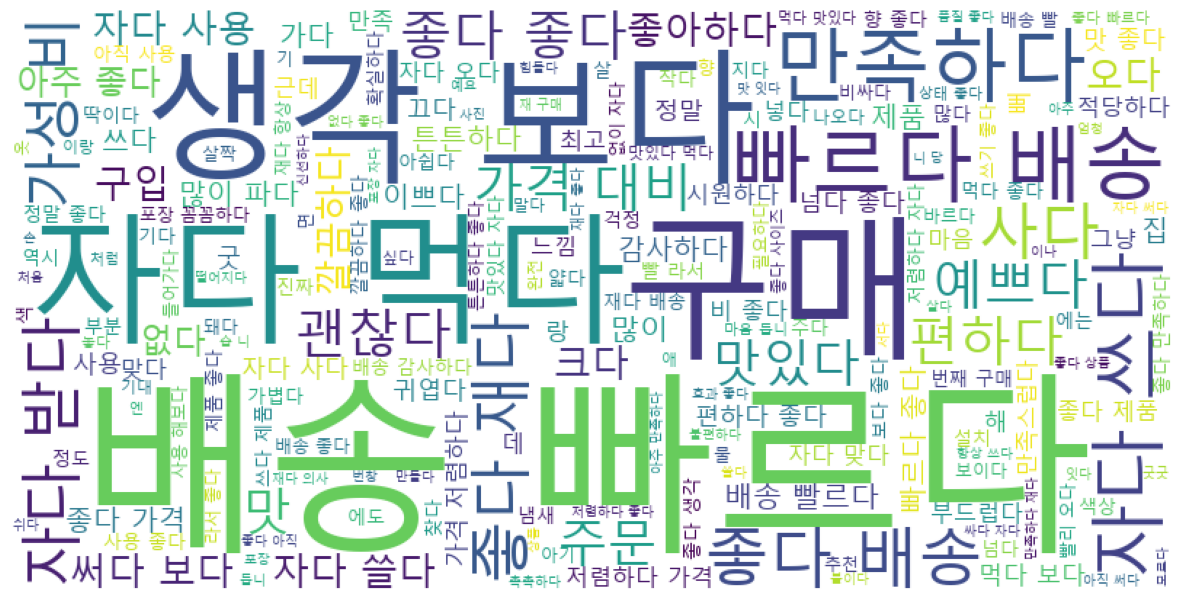

In [35]:
# 워드클라우드 생성
displayWordCloud(positive_text)

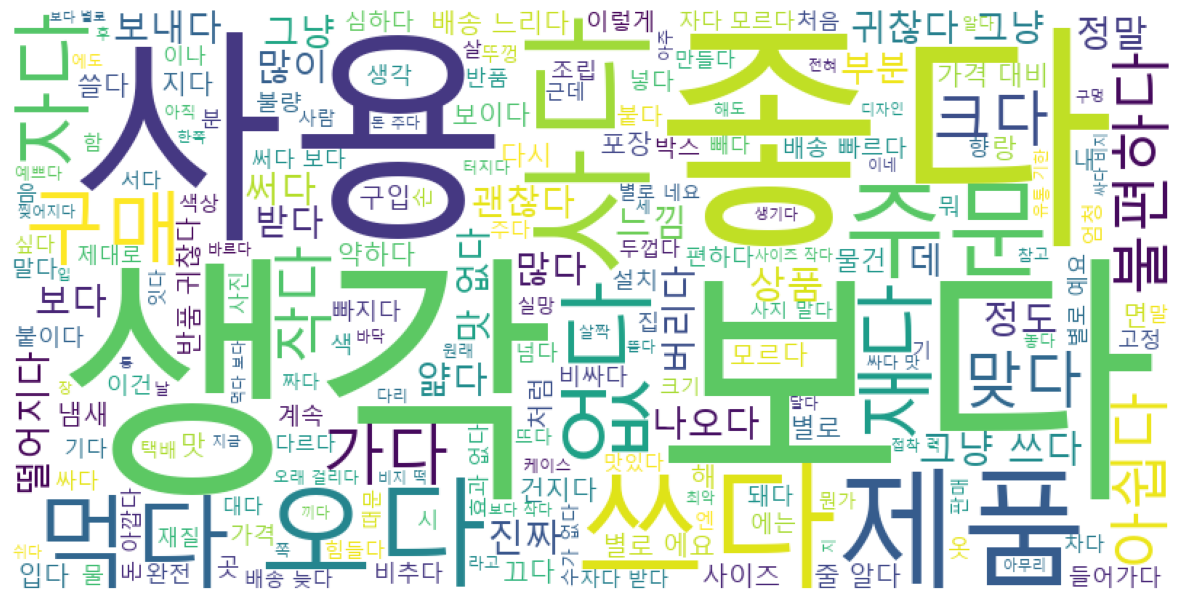

In [36]:
displayWordCloud(negative_text)

## 예시 2. LSTM을 이용한 쇼핑 리뷰 데이터 이진 분류 (w. Word2vec)

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_reviews'], data['label'], test_size=0.2, stratify= data['label'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [40]:
# 패딩
max_len = max(len(seq) for seq in X_train_encoded)
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len, padding='post')

EMBEDDING MATRIX 생성

In [41]:
# Word2Vec
embedding_dim = cbow.wv.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in cbow.wv:
        embedding_matrix[i] = cbow.wv[word]
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)   # 없는 단어는 0으로

MODELING

In [42]:
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],  # Word2Vec 임베딩 매트릭스 사용
                    input_length=max_len,
                    trainable=False))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/vision/anaconda3/envs/test/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [44]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.8505 - loss: 0.3665 - val_accuracy: 0.8789 - val_loss: 0.3053
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.8800 - loss: 0.3042 - val_accuracy: 0.8823 - val_loss: 0.2958
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 76s 38ms/step - accuracy: 0.8890 - loss: 0.2809 - val_accuracy: 0.8839 - val_loss: 0.2905
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 90s 45ms/step - accuracy: 0.8943 - loss: 0.2678 - val_accuracy: 0.8888 - val_loss: 0.2873
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 89s 45ms/step - accuracy: 0.8988 - loss: 0.2564 - val_accuracy: 0.8858 - val_loss: 0.2839


In [45]:
print("정확도 %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8898 - loss: 0.2826
정확도 0.8865
